# Predicting wine quality given chemical characteristics of the wine
by Yixuan Gao, Bryan Lee, Wangkai Zhu, Timothy Singh

## Summary

This project aims to build a machine learning model to classify the quality of red wine based on its physicochemical properties. The target variable, wine quality, is scored on a discrete scale from 0 (poor quality) to 10 (high quality), presenting a multi-class classification challenge. The dataset, sourced from the UC Irvine Machine Learning Repository, comprises 1,599 observations with 11 continuous features such as acidity, alcohol content, and citric acid.

Six (6) classification algorithms were evaluated: Dummy Classifier (as a baseline), Logistic Regression, Decision Tree, K-Nearest Neighbors (KNN), Naive Bayes and Support Vector Machine with a Radial Basis Function kernel (SVM RBF). 5-fold cross-validation was used with training data to find the best classification algorithm, based on accuracy, which was the SVM RBF model. Hyperparameter tuning was used to optimize this model and assess its generalization performance. The `C`, `gamma` and `decision_function_shape` hyperparameters on SVC were tuned using the `RandomizedSearchCV()` from `sklearn`. The model with hyperparameters that gave the best accuracy was selected for deployment on the test set. This model gave an accuracy on the testing set of around 0.6.

By leveraging machine learning, this project seeks to provide a systematic and measurable way to predict wine quality, aiding manufacturers and suppliers in assessing product value based on its chemical properties.

## Introduction:


Red wine has been a cultural and economic staple since ancient times, originating from early civilizations like the Greeks and evolving into a global industry valued at approximately 109.5 billion USD. Despite its widespread availability, differentiating between high and low-quality wines remains a challenge for most consumers. Traditionally, this task has relied on the expertise of sommeliers, whose judgments are often subjective.

This project aims to bridge the gap between subjective assessments and objective measurement by utilizing machine learning to predict wine quality. By analyzing the physicochemical properties of red wine—such as acidity, alcohol content, and sugar levels—we aim to classify its quality on a scale from 0 to 10.

Using the Red Wine Quality Dataset from the UC Irvine Machine Learning Repository, we evaluate the performance of several classification algorithms: Logistic Regression, Decision Tree, KNN, Naive Bayes and SVM with an RBF kernel. Through hyperparameter tuning and cross-validation, the goal is to identify the most accurate model and demonstrate the practical application of data-driven decision-making in the wine industry.

## Methods & Results:


### Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
import pandera as pa

In [2]:
df = pd.read_csv('../data/winequality_red.csv', sep = ';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


_Table 1: Preview of wine dataset to the used in analysis_

### Data Cleaning and Duplicates Handling

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

A thorough examination of the dataset revealed no missing values in any of the columns. This was verified by checking for null entries in all rows and columns using methods such as isnull() and info() in Python. 

In [5]:
duplicates = df[df.duplicated()]
print(duplicates)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4               7.4             0.700         0.00            1.90      0.076   
11              7.5             0.500         0.36            6.10      0.071   
27              7.9             0.430         0.21            1.60      0.106   
40              7.3             0.450         0.36            5.90      0.074   
65              7.2             0.725         0.05            4.65      0.086   
...             ...               ...          ...             ...        ...   
1563            7.2             0.695         0.13            2.00      0.076   
1564            7.2             0.695         0.13            2.00      0.076   
1567            7.2             0.695         0.13            2.00      0.076   
1581            6.2             0.560         0.09            1.70      0.053   
1596            6.3             0.510         0.13            2.30      0.076   

      free sulfur dioxide  

In [6]:
df = df.drop_duplicates()

### Columns

- fixed acidity: grams of tartaric acid per cubic decimeter.
- volatile acidity: grams of acetic acid per cubic decimeter.
- citric acid: grams of citric acid per cubic decimeter.
- residual sugar: grams of residual sugar per cubic decimeter.
- chlorides: grams of sodium chloride per cubic decimeter.
- free sulfur dioxide: grams of unreacted sulfur dioxide per cubic decimeter.
- total sulfur dioxide: grams of total sulfur dioxide per cubic decimeter.
- density: density of the wine in grams per cubic decimeter.
- pH: pH value of the wine
- sulphates: grams of potassium sulphate per cubic decimeter
- alcohol : percentage volume of alcohol content.
- quality : integer range from 0 (representing low-quality) to 10 (representing high-quality).

### Data Validation

In [7]:
# With reference to: 
# Machine Learning for Predicting Wine Quality and its Key Determinants Based on Physicochemical Properties SSRAML, 6(11), 1–21.

schema = pa.DataFrameSchema(
    {
        "fixed acidity": pa.Column(float, pa.Check(lambda s: (s > 0).all()), nullable=False),
        "volatile acidity": pa.Column(float, pa.Check(lambda s: (s > 0).all()), nullable=False),
        "citric acid": pa.Column(float, pa.Check(lambda s: (s >= 0).all()), nullable=False),
        "residual sugar": pa.Column(float, pa.Check(lambda s: (s >= 0).all()), nullable=False),
        "chlorides": pa.Column(float, pa.Check(lambda s: (s >= 0).all()), nullable=False),
        "free sulfur dioxide": pa.Column(float, pa.Check(lambda s: (s >= 0).all()), nullable=False),
        "total sulfur dioxide": pa.Column(float, pa.Check(lambda s: (s >= 0).all()), nullable=False),
        "density": pa.Column(float, pa.Check(lambda s: ((s >= 0.9) & (s <= 1.1)).all()), nullable=False),
        "pH": pa.Column(float, pa.Check(lambda s: ((s >= 0) & (s <= 14)).all()), nullable=False),
        "sulphates": pa.Column(float, pa.Check(lambda s: (s >= 0).all()), nullable=False),
        "alcohol": pa.Column(float, pa.Check(lambda s: ((s >= 5) & (s <= 20)).all()), nullable=False),
        "quality": pa.Column(int, pa.Check.isin(range(0, 11)), nullable=False),
    },
    checks=[
        # Check for duplicate rows at the DataFrame level
        pa.Check(lambda df: not df.duplicated().any(), error="Duplicate rows found."),
        # Check for empty rows (rows with all NaN values)
        pa.Check(lambda df: not (df.isna().all(axis=1)).any(), error="Empty rows found."),
    ]
)

In [8]:
schema.validate(df, lazy=True)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Data Splitting

In [9]:
# Creating our X and Y data
X = df.drop('quality', axis=1) 
y = df['quality']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Exploratory Data Analysis (EDA)

In [10]:
X_train.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1087.000000,8.329163,1.735780,4.600000,7.100000,7.900000,9.200000,15.900000
volatile acidity,1087.000000,0.530359,0.182572,0.120000,0.390000,0.520000,0.640000,1.580000
citric acid,1087.000000,0.270699,0.195515,0.000000,0.090000,0.250000,0.430000,1.000000
residual sugar,1087.000000,2.488914,1.252182,0.900000,1.900000,2.200000,2.600000,15.500000
chlorides,1087.000000,0.088105,0.050250,0.012000,0.070000,0.079000,0.090500,0.611000
free sulfur dioxide,1087.000000,15.987580,10.408577,1.000000,7.000000,14.000000,22.000000,72.000000
total sulfur dioxide,1087.000000,46.956302,33.611941,6.000000,22.000000,38.000000,62.500000,289.000000
density,1087.000000,0.996726,0.001867,0.990070,0.995600,0.996700,0.997860,1.003200
pH,1087.000000,3.309080,0.156245,2.740000,3.210000,3.310000,3.400000,4.010000
sulphates,1087.000000,0.655823,0.172391,0.330000,0.550000,0.620000,0.720000,2.000000


_Table 2: Summary of wine data set with highlighted extreme values_

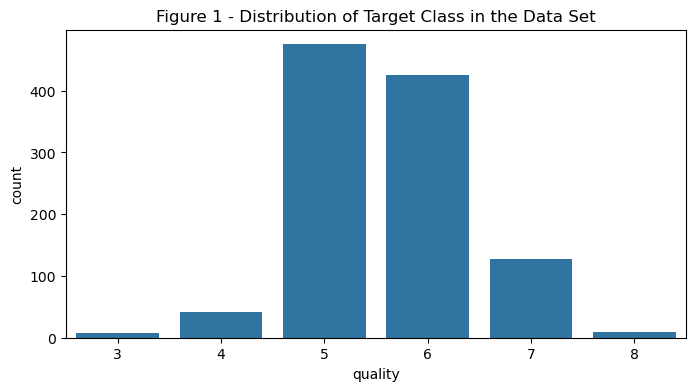

In [11]:
plt.figure(figsize=(8,4))
sns.countplot(x=y_train)
plt.title(f"Figure 1 - Distribution of Target Class in the Data Set")
plt.show()

_Figure 1: Distribution of target classes in the data set_

It is noted that not all possible target classes (from 0 to 10) are present in the training data.

For our Exploratory Data Analysis we wanted to see if our features have a linear correlation with each other and the target. The below plot is a heatmap which shows the pearson correlation. 

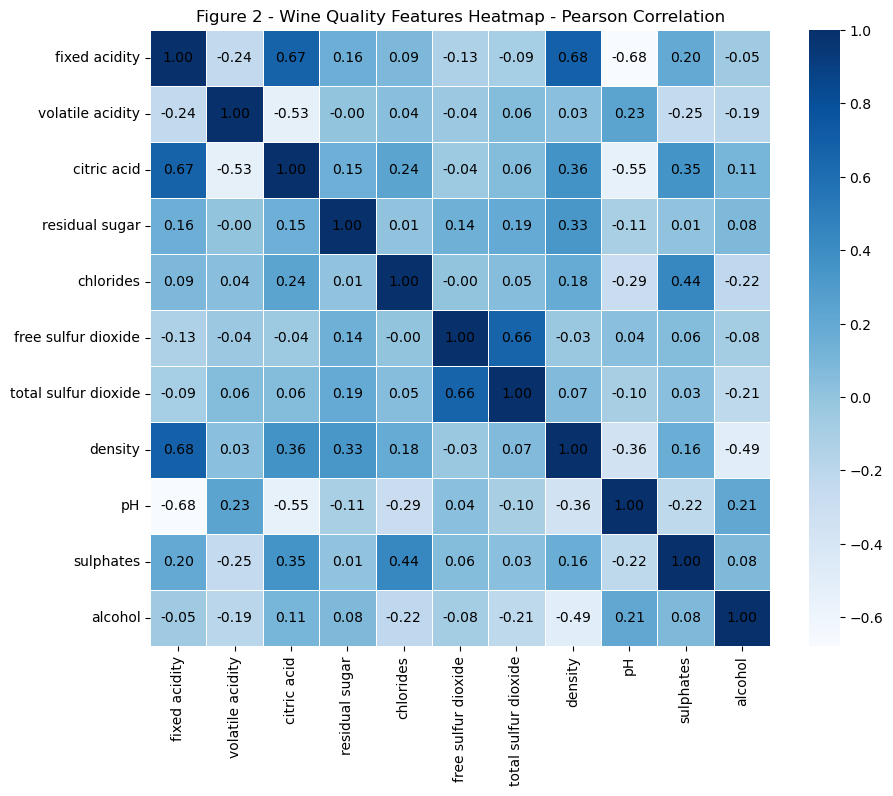

In [12]:
plt.figure(figsize=(10, 8)) 
correlation_matrix = X_train.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True, 
            annot_kws={'size': 10, 'color': 'black'}, linewidths=0.6)

plt.title(f"Figure 2 - Wine Quality Features Heatmap - Pearson Correlation")
plt.show()

_Figure 2 - Wine Quality Features Heatmap using Pearson Correlation"_

_Note that quality has the strongest r-square correlation with alchohol levels at 0.48, meaning alcohol levels is the feature with the highest linear relationship to the target, with sulphates having the second highest at 0.25._

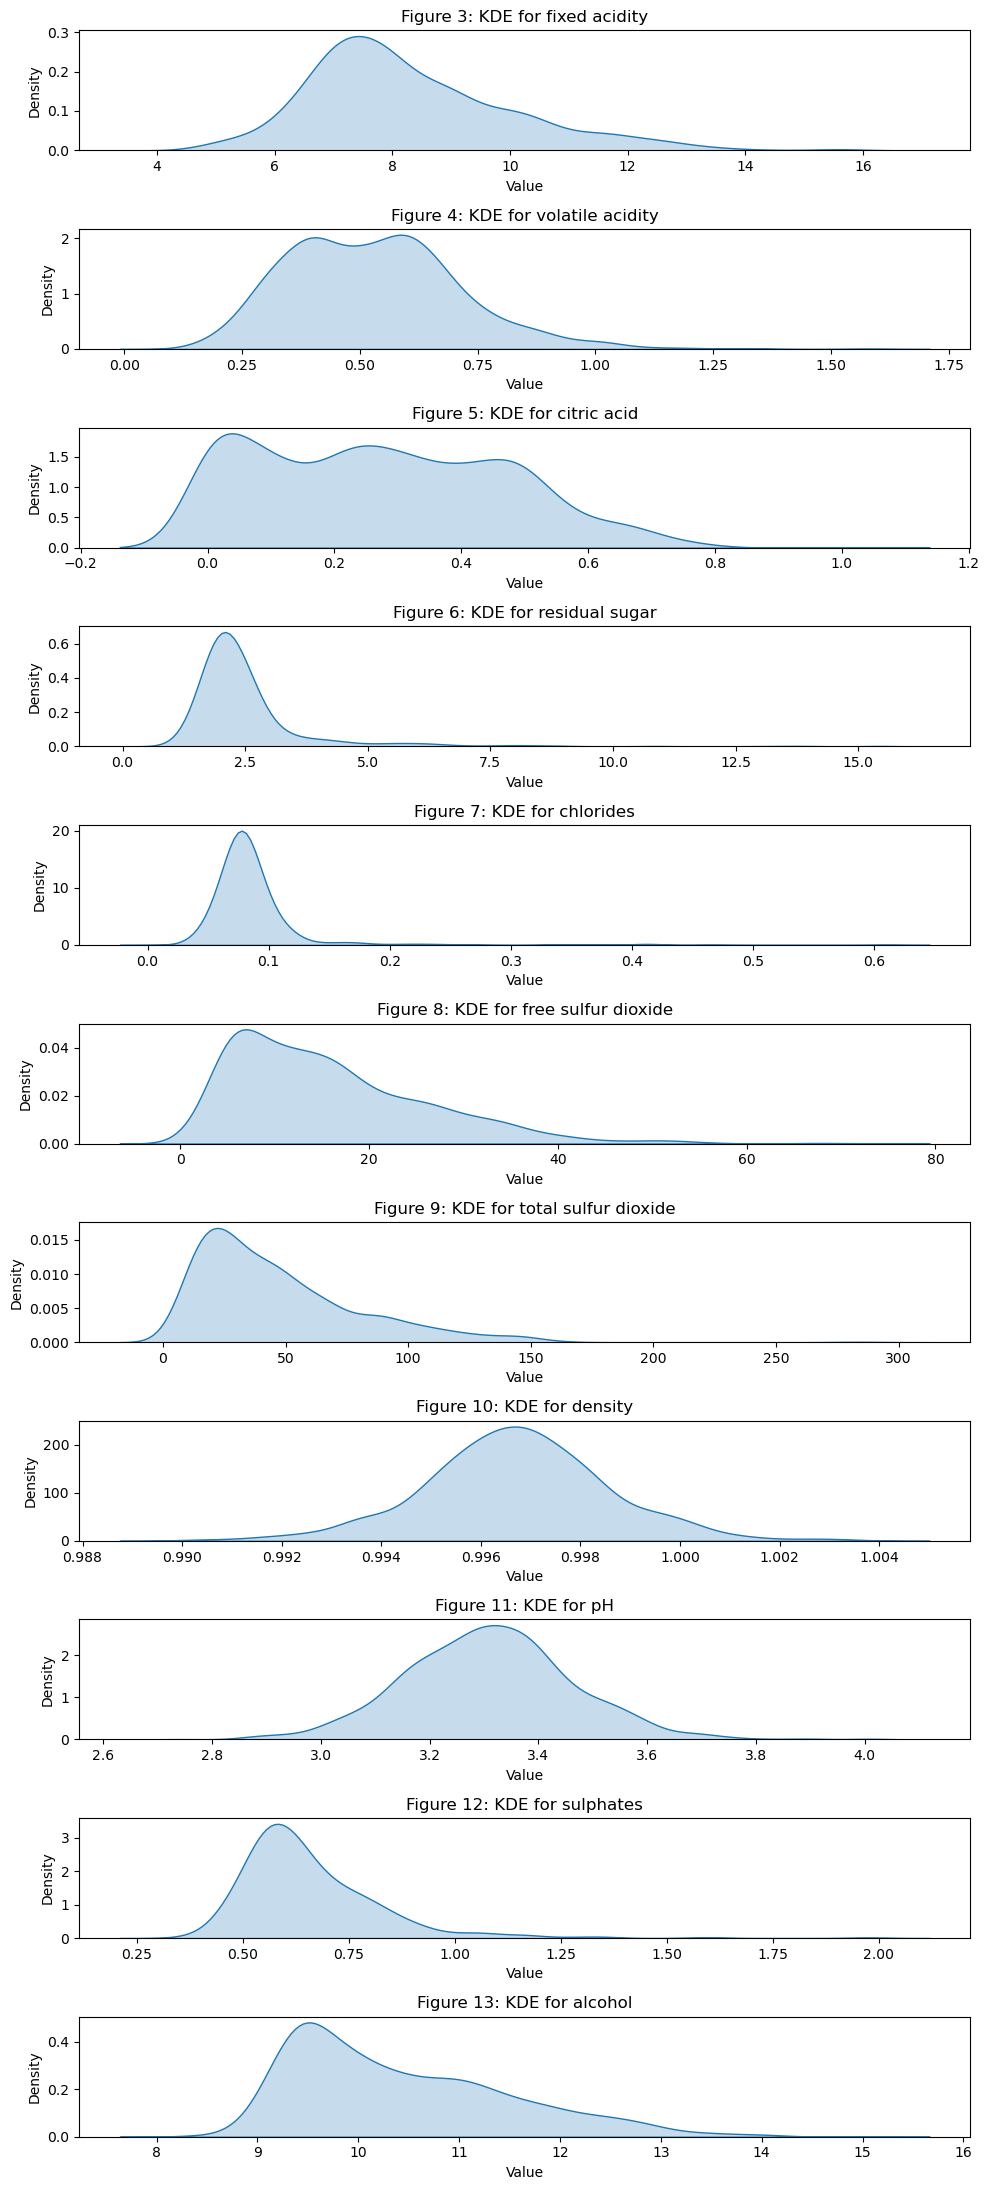

In [13]:
num_features = len(X_train.columns)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 2*num_features))

# Iterate over each feature and plot in a subplot
for i, column in enumerate(X_train.columns):
    sns.kdeplot(df[column], ax=axes[i], fill=True)
    axes[i].set_title(f"Figure {i+3}: KDE for {column}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()

_Figures 3-14: KDE plots for all features in data set_

The above is are KDE plots for all our features, so we can gain an understanding of the distribution for our features. Some notes that I have observed is that:
- It's noted that in our target feature "Quality" it seems that most of our data actually fall in the 5 and 6 range for score. To obtain a score of 8 and above looks to be quite rare and so our final results should be similar where only the strongest scoring wine will get a quality value of 8 and above.
- There are a few features which are normally distributed but not all of them. Alcohol for an example appears to skew to the right significantly. This means that wine will tend to not fall below a minimum alcohol level however the ceiling for alcohol is not as strict as the floor. Total and Free Sulfur Dioxide seems to have a similar distribution which skews slightly to the right but according to the heatmap above the correlation between Total and Free Sulfur Dioxide and alcohol content is not very strong.

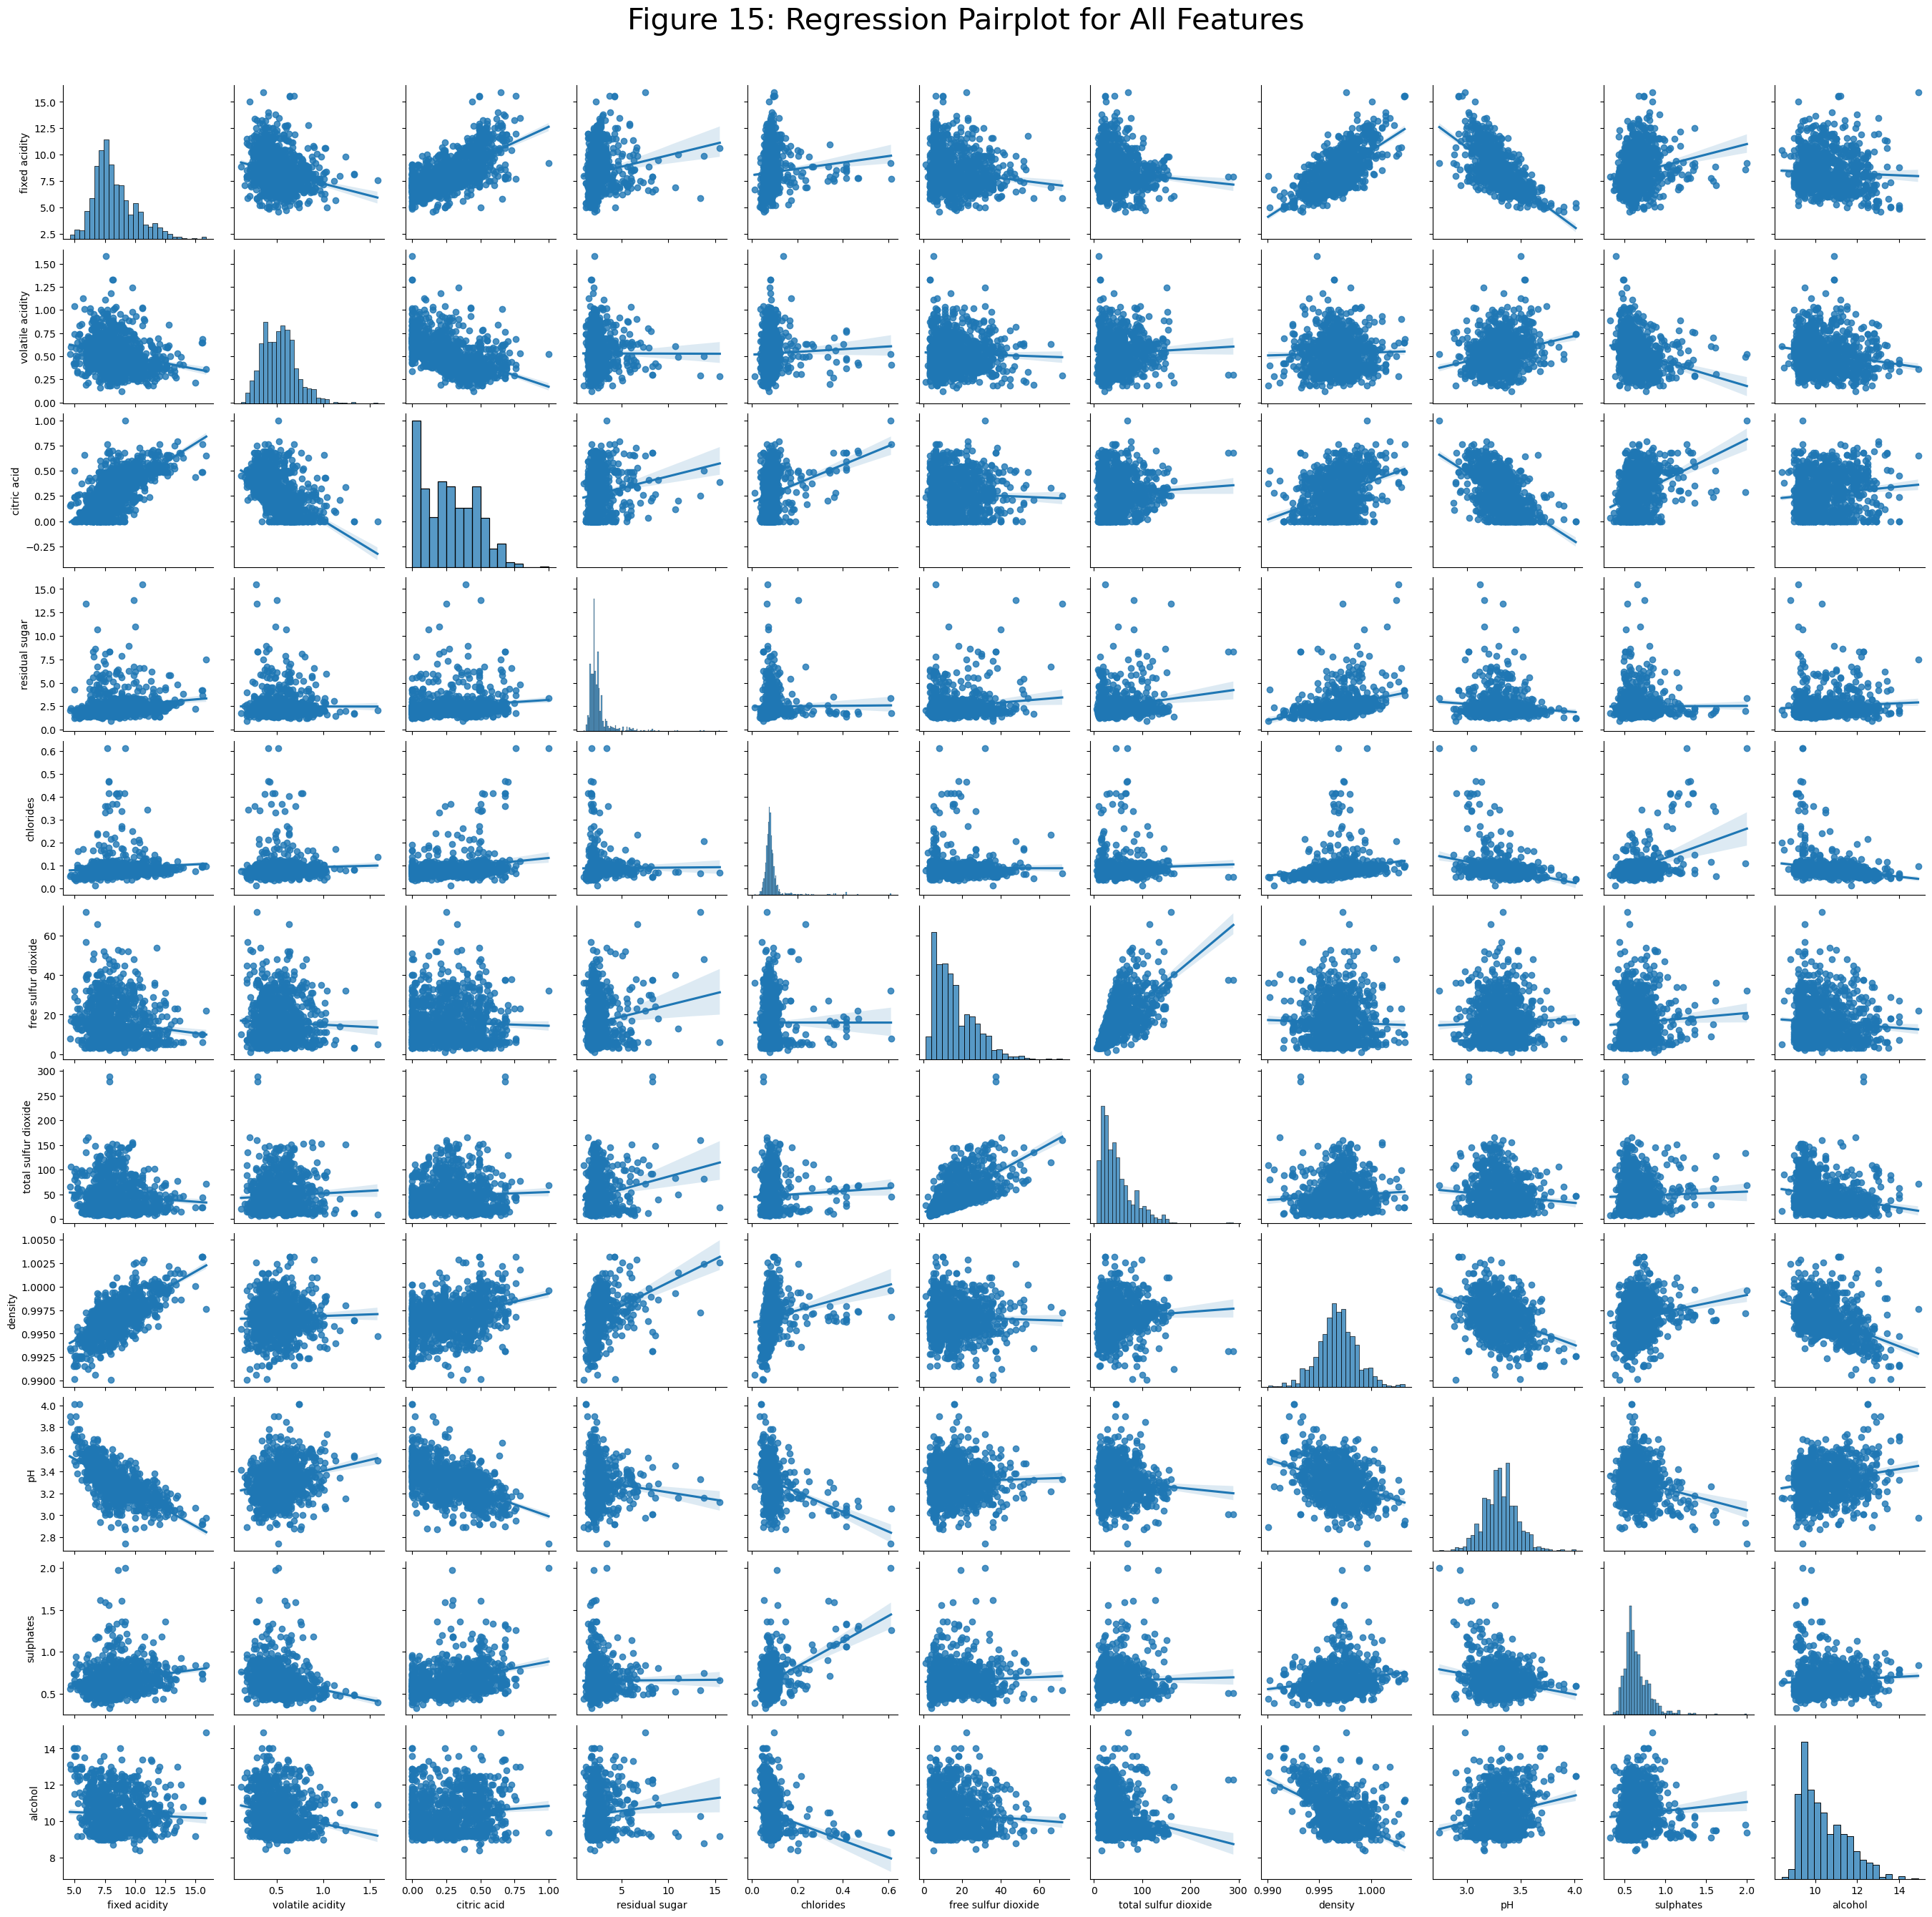

In [14]:
feature_pairplot = sns.pairplot(X_train, kind = 'reg', diag_kind = 'hist')
feature_pairplot.fig.suptitle('Figure 15: Regression Pairplot for All Features', size = 30)
feature_pairplot.fig.subplots_adjust(top = 0.94)

feature_pairplot

_Figure 15: Regression Pairplot for All Features_

### Analysis

In [15]:
# Creating Column Transformer
numeric_features = list(X.columns)

preprocessor = make_column_transformer((StandardScaler(), numeric_features))

In [16]:
# Creating function to return accuracy of from each trained model
def cross_val_scores(model, X_train, y_train):
    """
    Returns mean accuracy from 5-fold cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        values for features from training data
    y_train : numpy array or pandas Series
        values for target from training data

    Returns
    ----------
        pandas Series with all mean scores from cross_validation
    """

    scores = cross_validate(model, 
                            X_train, 
                            y_train, 
                            cv = 5, 
                            return_train_score = True
                            )
    
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    result_scores =[]
    for i in range(len(scores)):
        result_scores.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))


    return pd.Series(data=result_scores, index=mean_scores.index)

In [17]:
# Creation of model dictionary
models = {
    "dummy": DummyClassifier(),
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
    "naive bayes": GaussianNB(),
    "log reg": LogisticRegression()
}

# Creation of results dictionary
results= {}

In [18]:
# Creation of model pipelines and cross-evaluation
for model_key, model in models.items():
    model_pipeline = make_pipeline(
        preprocessor,
        model
    )

    results[model_key] = cross_val_scores(model_pipeline,
                                                   X_train,
                                                   y_train)

results_df = pd.DataFrame(results).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.039 (+/- 0.074),0.006 (+/- 0.005),0.437 (+/- 0.001),0.437 (+/- 0.000)
decision tree,0.021 (+/- 0.014),0.005 (+/- 0.001),0.500 (+/- 0.029),1.000 (+/- 0.000)
kNN,0.012 (+/- 0.006),0.027 (+/- 0.015),0.547 (+/- 0.019),0.688 (+/- 0.008)
RBF SVM,0.050 (+/- 0.014),0.017 (+/- 0.005),0.598 (+/- 0.030),0.669 (+/- 0.008)
naive bayes,0.007 (+/- 0.002),0.004 (+/- 0.001),0.545 (+/- 0.031),0.559 (+/- 0.021)
log reg,0.036 (+/- 0.009),0.005 (+/- 0.002),0.590 (+/- 0.032),0.609 (+/- 0.011)


_Table 3: Comparison of fit time, score time, testing score and validation scores for different models_

From these results, it appears that the RBF SVM model gives the best validation scores. Therefore, this model will be used for hyperparameter tuning in the following section.

In [ ]:
# Hyperparameter tuning for the best performing model
param_dist = {
    'svc__C': loguniform(1e-3, 1e3),
    'svc__gamma': loguniform(1e-3, 1e3),
    'svc__decision_function_shape': ['ovr', 'ovo'],
    'svc__class_weight': [None, 'balanced']
}

svc_tuning = make_pipeline(preprocessor, SVC())

random_search = RandomizedSearchCV(svc_tuning, param_dist, 
                                   n_iter=50, cv=5, n_jobs=-1)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

In [ ]:
# Using the model with the best hyperparameters on the testing set

best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
test_accuracy_df = pd.DataFrame({"accuracy": [test_score]})
test_accuracy_df

_Table 4: Accuracy of model with best hyperparameters on the testing set._

In [ ]:
# Multi-class Confusion Matrix
labels = np.unique(y_test)

y_pred = best_model.predict(X_test)
confusion_matrix = multilabel_confusion_matrix(y_test, y_pred, labels = labels)

# Iterate over each label's confusion matrix

# With reference to: sklearn.metrics.multilabel_confusion_matrix. In Scikit-learn documentation. 
# Retrieved November 23, 2024, from https://scikit-learn.org/dev/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html

for i in range(len(labels)):
    matrix = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix[i], 
                                    display_labels=["Not " + str(labels[i]), labels[i]])
    matrix.plot(cmap='Greens')  # Optional: use a color map to enhance visualization
    plt.title(f"Figure {i+16} - Confusion Matrix for Label: {labels[i]}")
    plt.show()

_Figures 16-21: Confusion matrices for testing data_

In [ ]:
columns = ["True Negative", "False Positive", "False Negative", "True Positive"]
 
# Create a DataFrame with proper column names and labels to summarize confusion matrices
conf_matrix_summary_df = pd.DataFrame(confusion_matrix.reshape(len(labels), -1), index=labels, columns=columns).T
conf_matrix_summary_df

_Table 5: Summary of Confusion Matrices_

## Discussion:


The evaluation of multiple machine learning models for classifying red wine quality revealed that the Support Vector Classifier (SVC) with a Radial Basis Function (RBF) kernel performed the best in terms of validation accuracy after hyperparameter tuning. The final testing accuracy (~0.6) demonstrated the model's ability to generalize fairly decently to unseen data. Among the other models, Logistic Regression also achieved a reasonable validation accuracy but fell short compared to the SVC RBF. The Decision Tree model exhibited overfitting, achieving perfect accuracy on the training data but only moderate validation accuracy. Models like k-Nearest Neighbors and Naive Bayes performed relatively poorly, with lower accuracies and limited predictive power.

Despite the superior accuracy of the SVC RBF model, it required the longest fit and score times, highlighting potential limitations in computational efficiency, particularly in scenarios requiring real-time predictions or processing large datasets.

The findings are somewhat aligned with expectations. The SVC RBF's strong performance is consistent with its reputation for handling complex, non-linear relationships in the data effectively. However, the overall accuracy (~0.6) is lower than ideal for a practical classification system, indicating challenges in predicting wine quality with high precision based solely on the physicochemical features provided. This outcome suggests that wine quality may be influenced by additional factors, such as sensory data or external conditions, that were not captured in the dataset.

The pronounced overfitting in the Decision Tree model and the relatively modest performance of simpler models like Naive Bayes and k-NN were expected, as these models are less equipped to capture intricate relationships in high-dimensional datasets.

The classification accuracy achieved in this project has implications for the practical applications of such models in the wine industry. While the model can provide a rough estimate of wine quality, its predictions may not be reliable enough for high-stakes decisions, such as pricing or marketing. However, it could still serve as a preliminary screening tool for winemakers to assess batches of wine based on their chemical profiles.

The findings also highlight the importance of computational efficiency. Although the SVC RBF model outperformed others in accuracy, its extended fit and score times may limit its usability in time-sensitive applications. This trade-off between accuracy and efficiency should be carefully considered when deploying the model. 

It should be noted that the predictions of targets of this problem have an inherent ordering from 1 to 10, where lower values suggest worse quality wine and higher values suggest better quality wine. 

This study raises several avenues for future exploration: 

* How would including additional physicochemical features or sensory attributes, such as taste or aroma, influence model performance? Similarly, would excluding less impactful features reduce noise and improve accuracy?
* Would increasing the dataset size or balancing the class distribution lead to better generalization performance?
* Will using a different kernel for the SVC yield greater performance?

<br>

## References

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision Support Systems, 47(4), 547-553. Retrieved from http://www3.dsi.uminho.pt/pcortez/wine/

UCI Machine Learning Repository. (n.d.). Wine quality dataset. Retrieved from https://archive.ics.uci.edu/dataset/186/wine+quality

Cortez, P., & Cerdeira, A. (2009). Modeling wine preferences by data mining from physicochemical properties. Retrieved from https://www.semanticscholar.org/paper/Modeling-wine-preferences-by-data-mining-from-Cortez-Cerdeira/bf15a0ccc14ac1deb5cea570c870389c16be019c

Jupyter Project. (n.d.). Working with Markdown cells. In Jupyter Notebook documentation. Retrieved November 23, 2024, from https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html

Scikit-learn Developers. (n.d.). sklearn.metrics.multilabel_confusion_matrix. In Scikit-learn documentation. Retrieved November 23, 2024, from https://scikit-learn.org/dev/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html

Török, D.F.,(2023). Machine Learning for Predicting Wine Quality and its Key Determinants Based on Physicochemical Properties SSRAML, 6(11), 1–21.